# **Sessa Empirical Estimator for Clustering**
## CIS 3203N GROUP 3

**Thesis Partner 1:** Dejito, Christine Ann  
**Thesis Partner 2:** Roca, Zophia Maureen  
**Date:** February 25, 2025  

---

### **Instructions** 
1. Read the Journals about the Sessa Empirical Estimator.
2. Convert the R codes into Python Codes (use jupyter notebook).
3. Using Simulated data (https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full) or a real world datasets of your choice (You can obtain it in Kaggle or in https://archive.ics.uci.edu/), perform the Sessa Empircal Estimator and generate some insights.
4. The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.
5. Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.
6. Do this with your thesis partner.
7. You can use any A.I. assistant.

---

### **Dataset**

The dataset **med.events** contains simulated medication event records for 100 patients, with the following key columns:
- **PATIENT_ID**: Unique identifier for each patient.
- **DATE**: The date of a medication event.
- **PERDAY**: Daily dosage prescribed.
- **CATEGORY**: ATC code for medication classification.
- **DURATION**: Duration of medication supply in days.
---

### **Description**
This notebook explores the **Sessa Empirical Estimator** for clustering medication adherence data using **K-Means** and **Hierarchical**. The goal is to analyze patterns in medication event intervals and evaluate the effectiveness of different clustering techniques.  

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

### Function for preparing data

In [7]:
def load_data(file_path, column_mapping=None):
    """
    Load medication data from CSV file with flexible column naming
    
    Args:
        file_path: Path to the CSV file
        column_mapping: Dictionary mapping expected column names to actual CSV column names
                       {'expected_name': 'actual_csv_name'}
    
    Returns:
        DataFrame with medication events
    """
    # Load the data
    try:
        # Read first few rows to inspect column names
        df_peek = pd.read_csv(file_path, nrows=5)
        actual_columns = df_peek.columns.tolist()
        print(f"Found columns in CSV: {', '.join(actual_columns)}")
        
        # If no mapping provided, try to guess based on common patterns
        if column_mapping is None:
            # Default mappings - modify these based on your actual CSV column names
            column_mapping = {
                'pnr': next((col for col in actual_columns if col.lower() in ['pnr', 'patient', 'patientid', 'patient_id', 'id']), None),
                'eksd': next((col for col in actual_columns if col.lower() in ['eksd', 'date', 'prescription_date', 'med_date', 'event_date']), None),
                'perday': next((col for col in actual_columns if col.lower() in ['perday', 'per_day', 'daily_dose', 'dose_per_day']), None),
                'ATC': next((col for col in actual_columns if col.lower() in ['atc', 'drug_code', 'med_code', 'medication']), None),
                'dur_original': next((col for col in actual_columns if col.lower() in ['dur_original', 'duration', 'orig_duration', 'prescribed_duration']), None)
            }
            
            # Print the guessed mapping
            print("Guessed column mapping:")
            for exp_col, actual_col in column_mapping.items():
                print(f"  {exp_col} -> {actual_col}")
            
            # Check if any mappings are missing
            missing_mappings = [exp for exp, act in column_mapping.items() if act is None]
            if missing_mappings:
                print(f"\nWARNING: Could not guess mappings for: {', '.join(missing_mappings)}")
                print("Please provide a column_mapping dictionary when calling the function.")
                print("Example: load_data('your_file.csv', {'pnr': 'patient_id', 'eksd': 'prescription_date', ...})")
                return None
        
        # Load the full data with the column mapping
        tidy = pd.read_csv(file_path)
        
        # Rename columns according to mapping
        rename_dict = {v: k for k, v in column_mapping.items() if v in tidy.columns}
        tidy = tidy.rename(columns=rename_dict)
        
        # Check for required columns after renaming
        required_columns = ['pnr', 'eksd', 'perday', 'ATC', 'dur_original']
        missing_columns = [col for col in required_columns if col not in tidy.columns]
        
        if missing_columns:
            print(f"Warning: Missing required columns after renaming: {missing_columns}")
            print("Expected columns: pnr, eksd, perday, ATC, dur_original")
            print("Please provide correct column mapping.")
            return None
            
        # Convert date column to datetime
        try:
            tidy['eksd'] = pd.to_datetime(tidy['eksd'])
        except:
            print("Warning: Could not convert 'eksd' column to datetime. Trying common formats...")
            
            # Try common date formats
            date_formats = ['%Y-%m-%d', '%m/%d/%Y', '%d/%m/%Y', '%Y/%m/%d', '%m-%d-%Y', '%d-%m-%Y']
            for date_format in date_formats:
                try:
                    tidy['eksd'] = pd.to_datetime(tidy['eksd'], format=date_format)
                    print(f"Successfully converted dates using format: {date_format}")
                    break
                except:
                    continue
            
            if not pd.api.types.is_datetime64_dtype(tidy['eksd']):
                print("Error: Could not convert 'eksd' column to datetime. Please check the date format.")
                return None
        
        # Sort by patient and date
        tidy = tidy.sort_values(['pnr', 'eksd'])
        
        # List unique ATC codes for user reference
        unique_atc = tidy['ATC'].unique()
        print(f"Found {len(unique_atc)} unique ATC codes: {', '.join(unique_atc)}")
        
        return tidy
        
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

### Function for Sessa Empirical Estimator using K-means Clustering

In [8]:
def sessa_kmeans(tidy, drug_code):
    """
    Implementation of Sessa Empirical Estimator using K-means clustering
    
    Args:
        tidy: DataFrame with medication events
        drug_code: ATC code to analyze
    
    Returns:
        DataFrame with added Median and Cluster columns
    """
    # Filter data for specific drug
    drug_data = tidy[tidy['ATC'] == drug_code].copy()
    
    if len(drug_data) == 0:
        print(f"No data found for drug code '{drug_code}'")
        return None, None, None, None
    
    print(f"Found {len(drug_data)} records for drug code '{drug_code}'")
    
    # Sort by patient and date, and calculate previous prescription date
    drug_data = drug_data.sort_values(['pnr', 'eksd'])
    drug_data['prev_eksd'] = drug_data.groupby('pnr')['eksd'].shift(1)
    
    # Remove rows with no previous prescription
    drug_see_p1 = drug_data.dropna(subset=['prev_eksd']).copy()
    
    if len(drug_see_p1) == 0:
        print(f"No patients with multiple prescriptions found for drug code '{drug_code}'")
        return None, None, None, None
    
    # Select one random prescription per patient
    drug_see_p1 = drug_see_p1.groupby('pnr').apply(lambda x: x.sample(1)).reset_index(drop=True)
    
    # Calculate event interval
    drug_see_p1['event_interval'] = (drug_see_p1['eksd'] - drug_see_p1['prev_eksd']).dt.days
    
    if len(drug_see_p1) < 3:
        print(f"Too few samples for clustering (n={len(drug_see_p1)}). Need at least 3 samples.")
        return None, None, None, None
    
    # Generate ECDF
    x = np.sort(drug_see_p1['event_interval'].values)
    y = np.arange(1, len(x) + 1) / len(x)
    
    # Create DataFrame for ECDF
    dfper = pd.DataFrame({'x': x, 'y': y})
    
    # Retain the 80% of the ECDF
    dfper = dfper[dfper['y'] <= 0.8].copy()
    
    if len(dfper) < 3:
        print(f"Too few samples after filtering (n={len(dfper)}). Need at least 3 samples.")
        return None, None, None, None
    
    # Plot original data
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(dfper['x'], dfper['y'], alpha=0.5)
    plt.title("80% ECDF")
    plt.xlabel("Event Interval (days)")
    plt.ylabel("Cumulative Probability")
    
    plt.subplot(1, 2, 2)
    plt.scatter(x, y, alpha=0.5)
    plt.title("100% ECDF")
    plt.xlabel("Event Interval (days)")
    plt.ylabel("Cumulative Probability")
    plt.tight_layout()
    
    # Filter the data
    ni = max(dfper['x'])
    drug_see_p2 = drug_see_p1[drug_see_p1['event_interval'] <= ni].copy()
    
    # Density plot of log event interval
    plt.figure(figsize=(10, 6))
    log_intervals = np.log(drug_see_p2['event_interval'].values)
    log_intervals = log_intervals[np.isfinite(log_intervals)]
    
    if len(log_intervals) > 0:
        sns.kdeplot(log_intervals)
        plt.title("Log(event interval)")
        plt.xlabel("Log(Days)")
        plt.ylabel("Density")
    
    # Scale the data for clustering
    a = np.array(dfper[['x']]).astype(float)
    
    # Determine optimal number of clusters using silhouette score
    max_n_clusters = min(9, len(dfper) - 1)  # Can't have more clusters than data points minus 1
    range_n_clusters = range(2, max_n_clusters + 1) if max_n_clusters >= 2 else range(2, 3)
    
    if len(range_n_clusters) == 0 or max_n_clusters < 2:
        print("Not enough data for multiple clusters, using 2 clusters.")
        range_n_clusters = range(2, 3)
    
    silhouette_avg = []
    for n_clusters in range_n_clusters:
        # Ensure we don't try more clusters than data points
        if n_clusters >= len(a):
            break
            
        kmeans = KMeans(n_clusters=n_clusters, random_state=1234)
        cluster_labels = kmeans.fit_predict(a)
        
        # Need at least 2 clusters for silhouette score
        if len(np.unique(cluster_labels)) > 1:
            silhouette_avg.append(silhouette_score(a, cluster_labels))
        else:
            silhouette_avg.append(0)  # Assign 0 score if only one cluster
    
    plt.figure(figsize=(10, 6))
    plt.plot(range_n_clusters, silhouette_avg, 'o-')
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Analysis for K-means Clustering")
    
    # Get optimal number of clusters
    if silhouette_avg:
        max_cluster = range_n_clusters[np.argmax(silhouette_avg)]
    else:
        max_cluster = 2  # Default to 2 clusters if silhouette analysis fails
    
    print(f"K-means optimal clusters: {max_cluster}")
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=max_cluster, random_state=1234)
    dfper['cluster'] = kmeans.fit_predict(a)
    
    # Calculate statistics for each cluster
    cluster_stats = pd.DataFrame()
    for cluster in dfper['cluster'].unique():
        cluster_data = dfper[dfper['cluster'] == cluster]['x']
        if len(cluster_data) > 0:
            log_data = np.log(cluster_data)
            
            # Handle -inf values from log(0)
            log_data_min = log_data.min()
            if np.isinf(log_data_min) and log_data_min < 0:
                log_data_min = 0
                
            stats_row = pd.DataFrame({
                'Cluster': [cluster],
                'Minimum': [np.exp(log_data_min)],
                'Maximum': [np.exp(log_data.max())],
                'Median': [np.exp(np.median(log_data))]
            })
            cluster_stats = pd.concat([cluster_stats, stats_row], ignore_index=True)
    
    # Find the most frequent cluster
    cluster_counts = dfper['cluster'].value_counts()
    most_frequent_cluster = cluster_counts.idxmax()
    
    # Get the median for the most frequent cluster
    default_median = cluster_stats[cluster_stats['Cluster'] == most_frequent_cluster]['Median'].values[0]
    
    # Assign cluster and median to original data
    drug_see_p1_subset = drug_see_p1[['pnr', 'event_interval']].copy()
    
    # Create results by matching intervals to cluster ranges
    results = pd.DataFrame()
    for index, row in cluster_stats.iterrows():
        mask = (drug_see_p1_subset['event_interval'] >= row['Minimum']) & (drug_see_p1_subset['event_interval'] <= row['Maximum'])
        if mask.any():
            subset = drug_see_p1_subset[mask].copy()
            subset['Median'] = row['Median']
            subset['Cluster'] = row['Cluster']
            results = pd.concat([results, subset], ignore_index=True)
    
    # Merge results back to original data
    final_result = pd.merge(drug_data, 
                            results[['pnr', 'Median', 'Cluster']], 
                            on='pnr', 
                            how='left')
    
    # Fill missing values with default
    final_result['Median'] = final_result['Median'].fillna(default_median)
    final_result['Cluster'] = final_result['Cluster'].fillna(0)
    
    return final_result, cluster_stats, most_frequent_cluster, default_median

### Function for Sessa Empirical Estimator using Hierarchical Clustering

In [9]:
def sessa_hierarchical(tidy, drug_code):
    """
    Implementation of Sessa Empirical Estimator using Hierarchical clustering
    
    Args:
        tidy: DataFrame with medication events
        drug_code: ATC code to analyze
    
    Returns:
        DataFrame with added Median and Cluster columns
    """
    # Filter data for specific drug
    drug_data = tidy[tidy['ATC'] == drug_code].copy()
    
    if len(drug_data) == 0:
        print(f"No data found for drug code '{drug_code}'")
        return None, None, None, None
    
    print(f"Found {len(drug_data)} records for drug code '{drug_code}' (Hierarchical)")
    
    # Sort by patient and date, and calculate previous prescription date
    drug_data = drug_data.sort_values(['pnr', 'eksd'])
    drug_data['prev_eksd'] = drug_data.groupby('pnr')['eksd'].shift(1)
    
    # Remove rows with no previous prescription
    drug_see_p1 = drug_data.dropna(subset=['prev_eksd']).copy()
    
    if len(drug_see_p1) == 0:
        print(f"No patients with multiple prescriptions found for drug code '{drug_code}'")
        return None, None, None, None
    
    # Select one random prescription per patient
    drug_see_p1 = drug_see_p1.groupby('pnr').apply(lambda x: x.sample(1)).reset_index(drop=True)
    
    # Calculate event interval
    drug_see_p1['event_interval'] = (drug_see_p1['eksd'] - drug_see_p1['prev_eksd']).dt.days
    
    if len(drug_see_p1) < 3:
        print(f"Too few samples for clustering (n={len(drug_see_p1)}). Need at least 3 samples.")
        return None, None, None, None
    
    # Generate ECDF
    x = np.sort(drug_see_p1['event_interval'].values)
    y = np.arange(1, len(x) + 1) / len(x)
    
    # Create DataFrame for ECDF
    dfper = pd.DataFrame({'x': x, 'y': y})
    
    # Retain the 80% of the ECDF
    dfper = dfper[dfper['y'] <= 0.8].copy()
    
    if len(dfper) < 3:
        print(f"Too few samples after filtering (n={len(dfper)}). Need at least 3 samples.")
        return None, None, None, None
    
    # Plot original data
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(dfper['x'], dfper['y'], alpha=0.5)
    plt.title("80% ECDF (Hierarchical)")
    plt.xlabel("Event Interval (days)")
    plt.ylabel("Cumulative Probability")
    
    plt.subplot(1, 2, 2)
    plt.scatter(x, y, alpha=0.5)
    plt.title("100% ECDF (Hierarchical)")
    plt.xlabel("Event Interval (days)")
    plt.ylabel("Cumulative Probability")
    plt.tight_layout()
    
    # Filter the data
    ni = max(dfper['x'])
    drug_see_p2 = drug_see_p1[drug_see_p1['event_interval'] <= ni].copy()
    
    # Density plot of log event interval
    plt.figure(figsize=(10, 6))
    log_intervals = np.log(drug_see_p2['event_interval'].values)
    log_intervals = log_intervals[np.isfinite(log_intervals)]
    
    if len(log_intervals) > 0:
        sns.kdeplot(log_intervals)
        plt.title("Log(event interval) - Hierarchical")
        plt.xlabel("Log(Days)")
        plt.ylabel("Density")
    
    # Scale the data for clustering
    a = np.array(dfper[['x']]).astype(float)
    
    # Determine optimal number of clusters using silhouette score
    max_n_clusters = min(9, len(dfper) - 1)  # Can't have more clusters than data points minus 1
    range_n_clusters = range(2, max_n_clusters + 1) if max_n_clusters >= 2 else range(2, 3)
    
    if len(range_n_clusters) == 0 or max_n_clusters < 2:
        print("Not enough data for multiple clusters, using 2 clusters.")
        range_n_clusters = range(2, 3)
    
    silhouette_avg = []
    for n_clusters in range_n_clusters:
        # Ensure we don't try more clusters than data points
        if n_clusters >= len(a):
            break
            
        hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
        cluster_labels = hierarchical.fit_predict(a)
        
        # Need at least 2 clusters for silhouette score
        if len(np.unique(cluster_labels)) > 1:
            silhouette_avg.append(silhouette_score(a, cluster_labels))
        else:
            silhouette_avg.append(0)  # Assign 0 score if only one cluster
    
    plt.figure(figsize=(10, 6))
    plt.plot(range_n_clusters, silhouette_avg, 'o-')
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Analysis for Hierarchical Clustering")
    
    # Get optimal number of clusters
    if silhouette_avg:
        max_cluster = range_n_clusters[np.argmax(silhouette_avg)]
    else:
        max_cluster = 2  # Default to 2 clusters if silhouette analysis fails
    
    print(f"Hierarchical optimal clusters: {max_cluster}")
    
    # Apply Hierarchical clustering
    hierarchical = AgglomerativeClustering(n_clusters=max_cluster)
    dfper['cluster'] = hierarchical.fit_predict(a)
    
    # Calculate statistics for each cluster
    cluster_stats = pd.DataFrame()
    for cluster in dfper['cluster'].unique():
        cluster_data = dfper[dfper['cluster'] == cluster]['x']
        if len(cluster_data) > 0:
            log_data = np.log(cluster_data)
            
            # Handle -inf values from log(0)
            log_data_min = log_data.min()
            if np.isinf(log_data_min) and log_data_min < 0:
                log_data_min = 0
                
            stats_row = pd.DataFrame({
                'Cluster': [cluster],
                'Minimum': [np.exp(log_data_min)],
                'Maximum': [np.exp(log_data.max())],
                'Median': [np.exp(np.median(log_data))]
            })
            cluster_stats = pd.concat([cluster_stats, stats_row], ignore_index=True)
    
    # Find the most frequent cluster
    cluster_counts = dfper['cluster'].value_counts()
    most_frequent_cluster = cluster_counts.idxmax()
    
    # Get the median for the most frequent cluster
    default_median = cluster_stats[cluster_stats['Cluster'] == most_frequent_cluster]['Median'].values[0]
    
    # Assign cluster and median to original data
    drug_see_p1_subset = drug_see_p1[['pnr', 'event_interval']].copy()
    
    # Create results by matching intervals to cluster ranges
    results = pd.DataFrame()
    for index, row in cluster_stats.iterrows():
        mask = (drug_see_p1_subset['event_interval'] >= row['Minimum']) & (drug_see_p1_subset['event_interval'] <= row['Maximum'])
        if mask.any():
            subset = drug_see_p1_subset[mask].copy()
            subset['Median'] = row['Median']
            subset['Cluster'] = row['Cluster']
            results = pd.concat([results, subset], ignore_index=True)
    
    # Merge results back to original data
    final_result = pd.merge(drug_data, 
                            results[['pnr', 'Median', 'Cluster']], 
                            on='pnr', 
                            how='left')
    
    # Fill missing values with default
    final_result['Median'] = final_result['Median'].fillna(default_median)
    final_result['Cluster'] = final_result['Cluster'].fillna(0)
    
    return final_result, cluster_stats, most_frequent_cluster, default_median

### Function for Sessa Empirical Estimator Assumption

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

def see_assumption(data):
    """
    Check clustering assumptions by analyzing the distributions of event intervals
    
    Args:
        data: DataFrame with medication events and Median column
    
    Returns:
        None (Displays the plot without returning it)
    """
    if data is None:
        print("No data available to check assumptions")
        return
    
    # Sort by patient and date, and calculate previous prescription date
    data = data.sort_values(['pnr', 'eksd'])
    data['prev_eksd'] = data.groupby('pnr')['eksd'].shift(1)
    
    # Calculate prescription number and duration
    data['p_number'] = data.groupby('pnr').cumcount() + 1
    data = data[data['p_number'] >= 2].copy()
    data['Duration'] = (data['eksd'] - data['prev_eksd']).dt.days
    
    if len(data) == 0:
        print("No data available after filtering for prescription number")
        plt.figure()
        plt.text(0.5, 0.5, "No data available", horizontalalignment='center', verticalalignment='center')
        plt.show()
        return
    
    # Calculate median duration per patient
    medians_of_medians = data.groupby('pnr')['Duration'].median().median()
    
    # Create boxplot
    plt.figure(figsize=(12, 6))
    
    # Convert p_number to string for better visualization
    data['p_number'] = data['p_number'].astype(str)
    
    # Only include p_numbers that have sufficient data
    p_counts = data['p_number'].value_counts()
    valid_p = p_counts[p_counts >= 5].index if len(p_counts[p_counts >= 5]) > 0 else p_counts.index
    plot_data = data[data['p_number'].isin(valid_p)]
    
    if len(plot_data) == 0:
        plt.text(0.5, 0.5, "Insufficient data points per prescription number", 
                 horizontalalignment='center', verticalalignment='center')
    else:
        sns.boxplot(x='p_number', y='Duration', data=plot_data)
        plt.axhline(y=medians_of_medians, linestyle='--', color='red')
        plt.title("Duration by Prescription Number")
        plt.xlabel("Prescription Number")
        plt.ylabel("Duration (days)")
    
    plt.show()  # Show the plot instead of returning plt

## **Implementation**

In [44]:
tidy = load_data("med_events.csv", column_mapping)

Found columns in CSV: PATIENT_ID, DATE, PERDAY, CATEGORY, DURATION
Found 2 unique ATC codes: medA, medB


### 1. Sessa Empirical Estimator using K-means Clustering

Found 549 records for drug code 'medA'
K-means optimal clusters: 2


,pnr,eksd,perday,ATC,dur_original,prev_eksd,Median,Cluster
0,1,2033-04-26,4,medA,50,NaT,39.949969,0.0
1,2,2036-01-20,4,medA,50,NaT,39.949969,0.0
2,2,2036-03-10,4,medA,50,2036-01-20,39.949969,0.0
3,2,2036-08-01,4,medA,50,2036-03-10,39.949969,0.0
4,3,2042-04-13,4,medA,50,NaT,39.949969,0.0
...,...,...,...,...,...,...,...,...
544,99,2031-11-08,4,medA,50,NaT,39.949969,0.0
545,99,2032-06-16,4,medA,50,2031-11-08,39.949969,0.0
546,99,2032-09-18,4,medA,50,2032-06-16,39.949969,0.0
547,100,2032-08-05,2,medA,150,NaT,109.995454,1.0


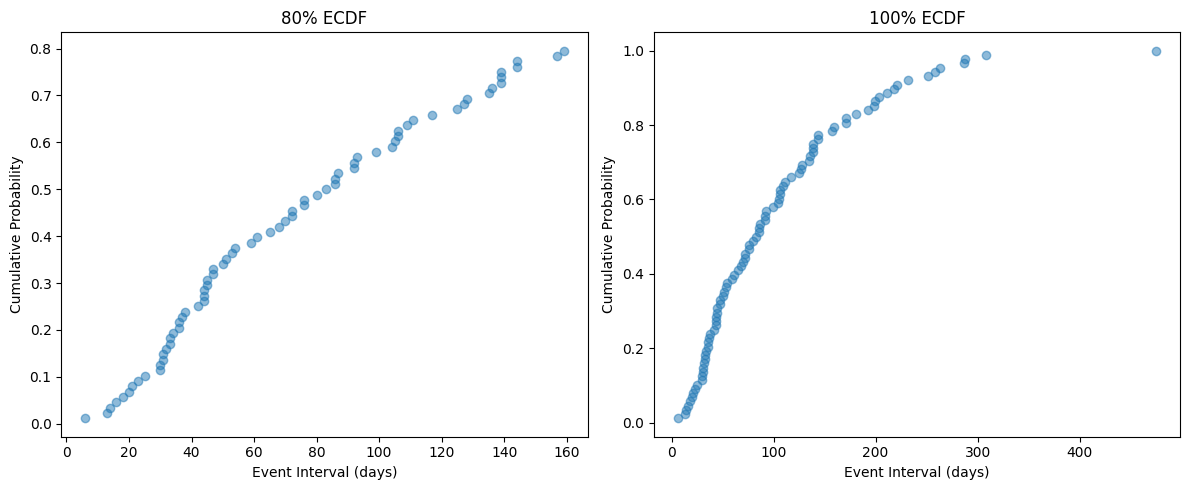

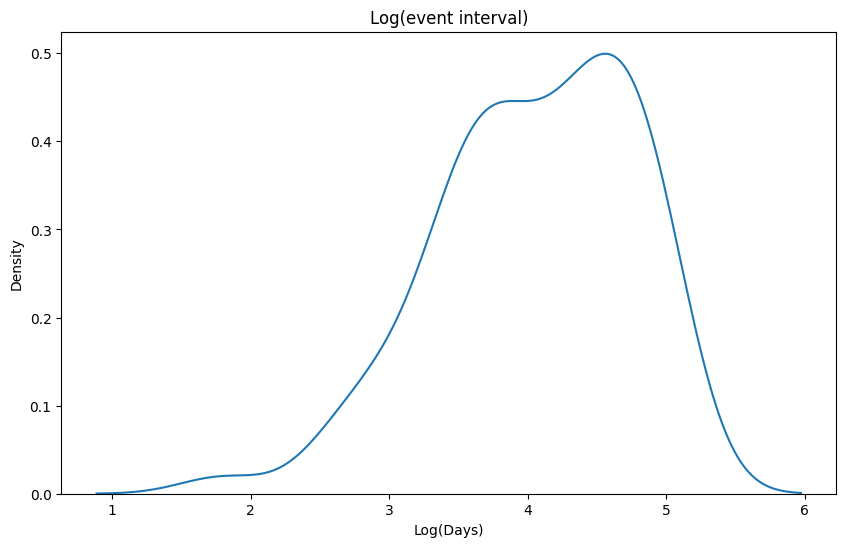

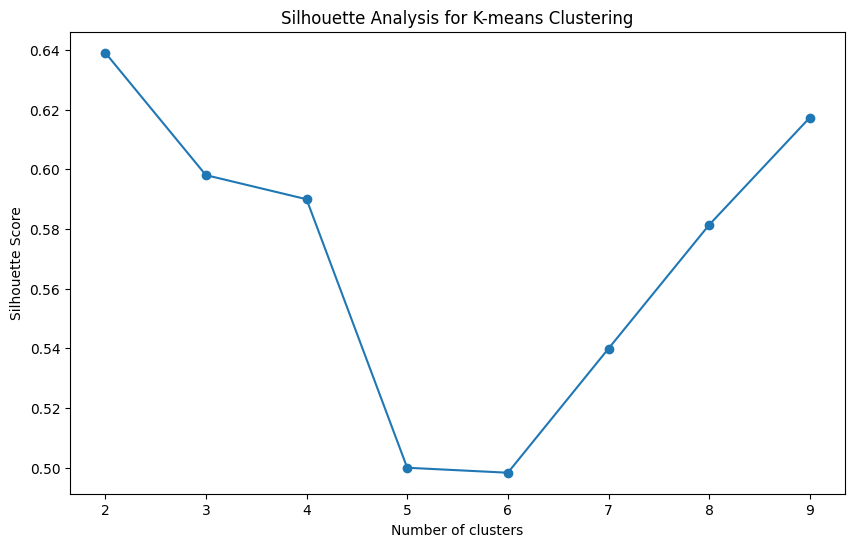

In [61]:
result = sessa_kmeans(tidy, "medA")
med_a = result[0]
med_a

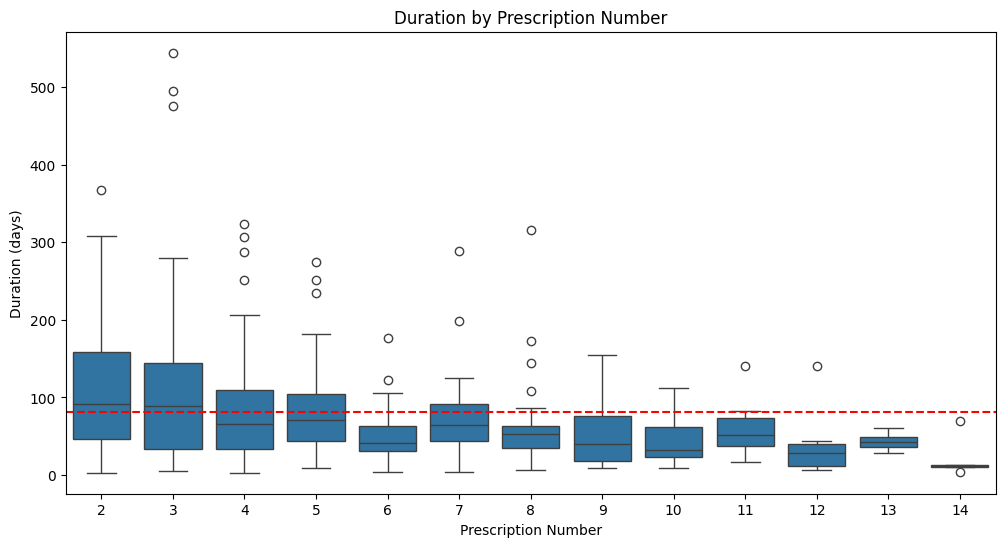

In [62]:
see_assumption(med_a)

Found 531 records for drug code 'medB'
K-means optimal clusters: 9


,pnr,eksd,perday,ATC,dur_original,prev_eksd,Median,Cluster
0,1,2033-07-04,4,medB,30,NaT,34.0,6.0
1,1,2033-08-03,4,medB,30,2033-07-04,34.0,6.0
2,1,2033-08-17,4,medB,30,2033-08-03,34.0,6.0
3,1,2033-10-13,4,medB,30,2033-08-17,34.0,6.0
4,1,2033-10-16,4,medB,30,2033-10-13,34.0,6.0
...,...,...,...,...,...,...,...,...
526,100,2034-03-05,6,medB,30,2034-01-22,34.0,6.0
527,100,2034-04-07,6,medB,30,2034-03-05,34.0,6.0
528,100,2034-04-26,6,medB,30,2034-04-07,34.0,6.0
529,100,2034-05-26,6,medB,30,2034-04-26,34.0,6.0


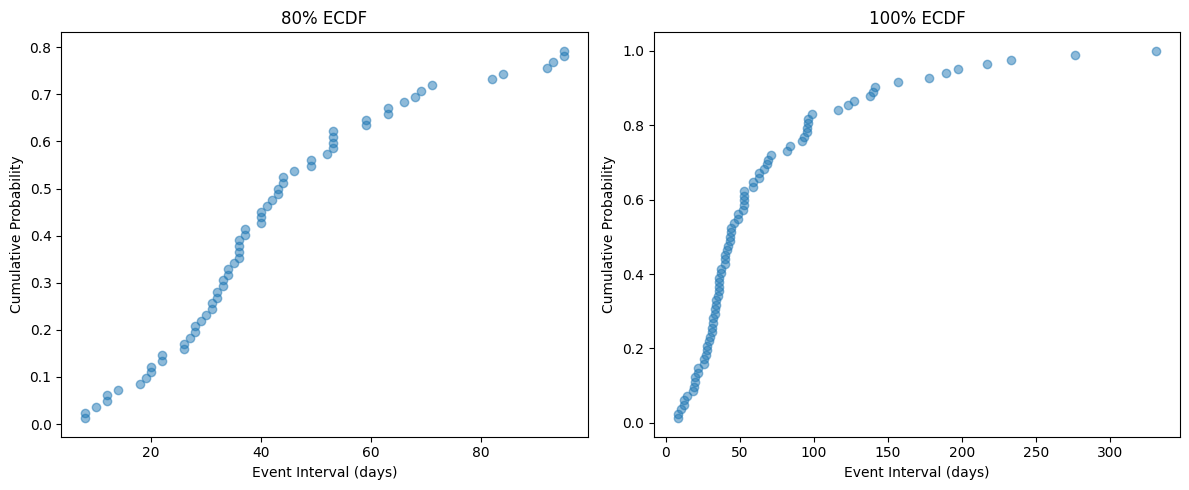

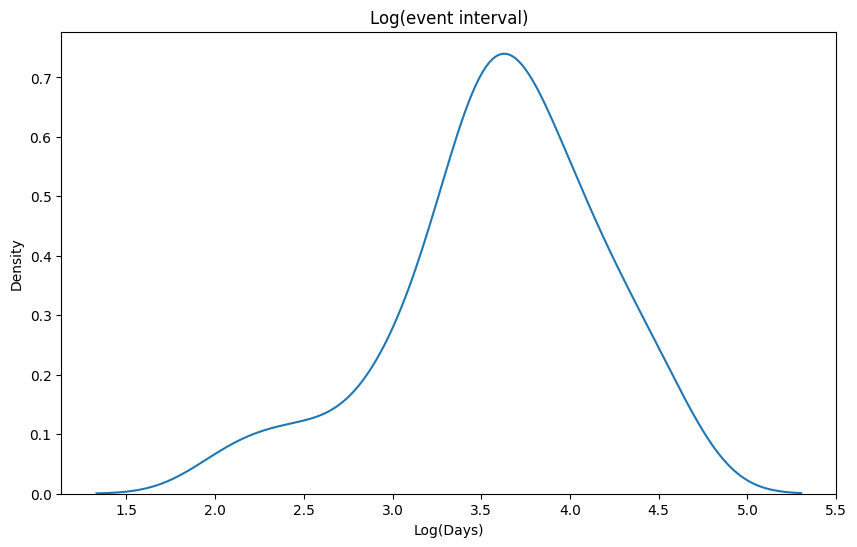

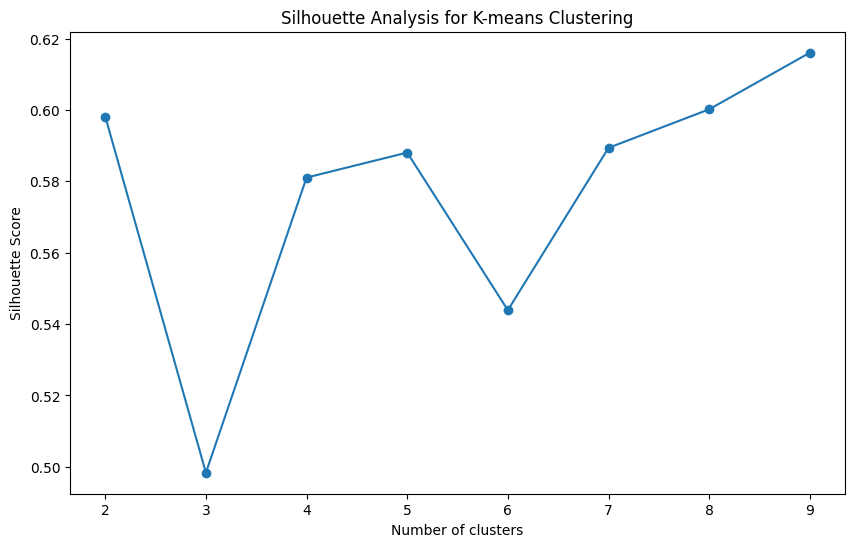

In [63]:
result = sessa_kmeans(tidy, "medB")
med_b = result[0]
med_b

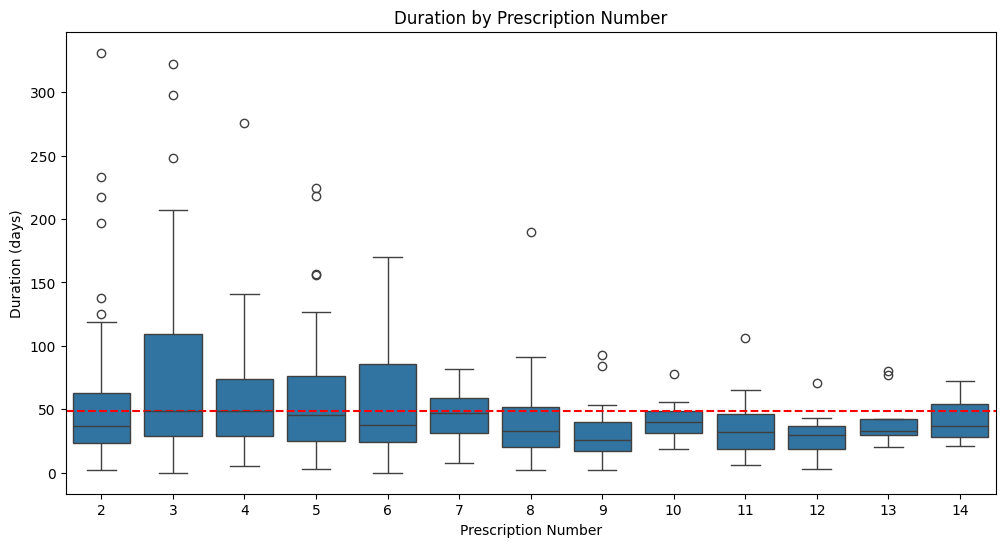

In [64]:
see_assumption(med_b)

### 2. Sessa Empirical Estimator using Hierarchical Clustering

Found 549 records for drug code 'medA' (Hierarchical)
Hierarchical optimal clusters: 7


,pnr,eksd,perday,ATC,dur_original,prev_eksd,Median,Cluster
0,1,2033-04-26,4,medA,50,NaT,52.0,0.0
1,2,2036-01-20,4,medA,50,NaT,52.0,6.0
2,2,2036-03-10,4,medA,50,2036-01-20,52.0,6.0
3,2,2036-08-01,4,medA,50,2036-03-10,52.0,6.0
4,3,2042-04-13,4,medA,50,NaT,52.0,0.0
...,...,...,...,...,...,...,...,...
544,99,2031-11-08,4,medA,50,NaT,78.0,0.0
545,99,2032-06-16,4,medA,50,2031-11-08,78.0,0.0
546,99,2032-09-18,4,medA,50,2032-06-16,78.0,0.0
547,100,2032-08-05,2,medA,150,NaT,164.0,1.0


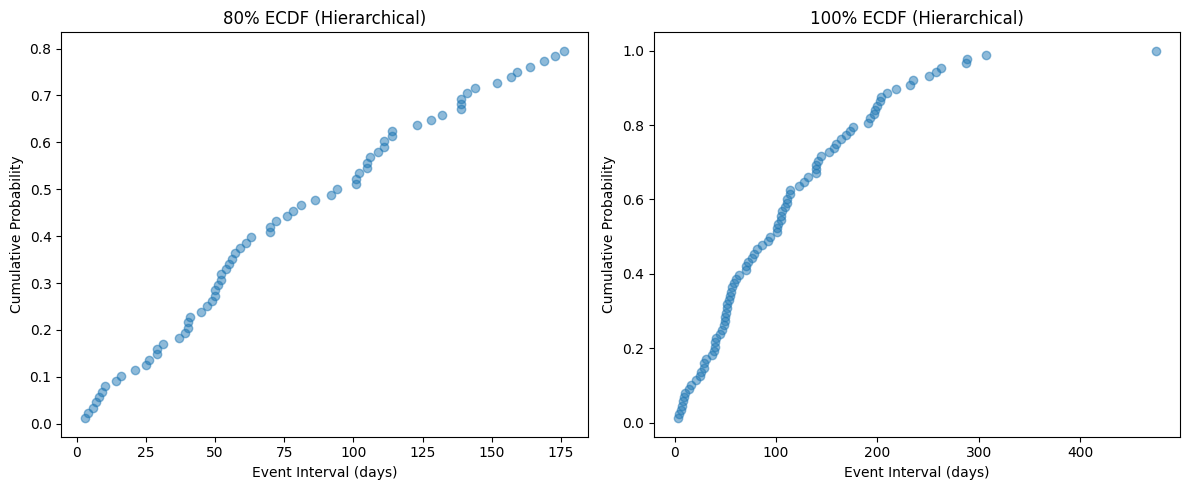

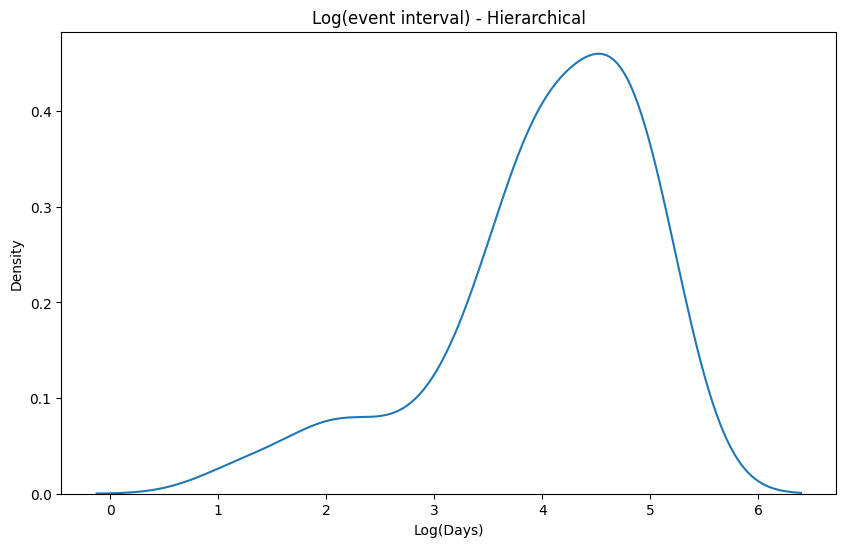

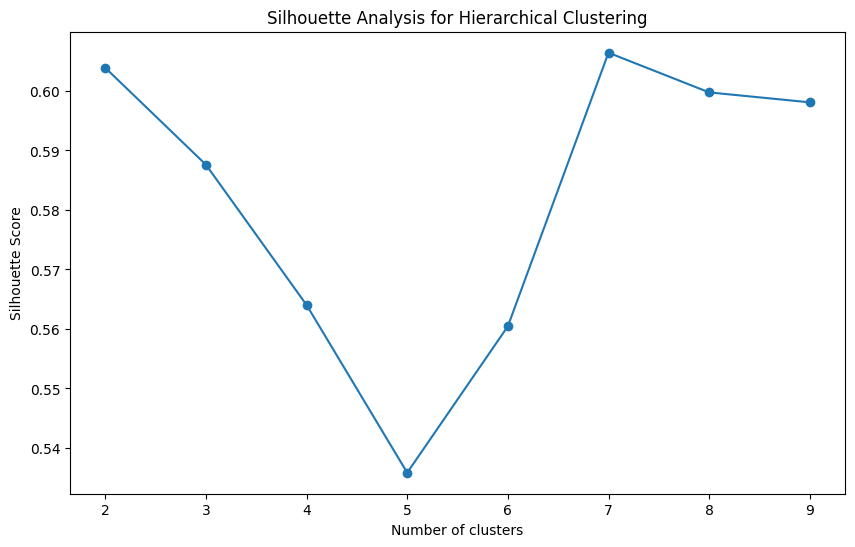

In [65]:
result = sessa_hierarchical(tidy, "medA")
med_a_H = result[0]
med_a_H

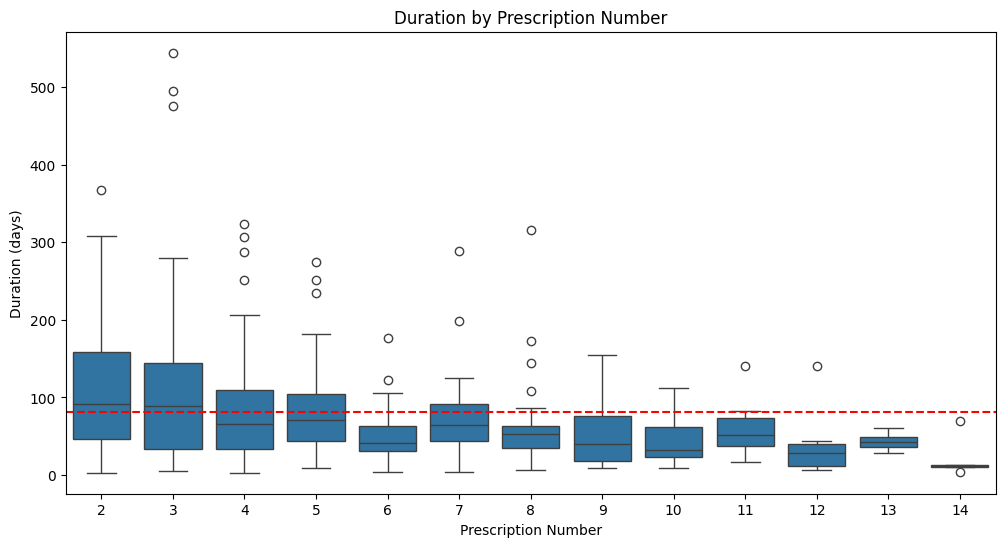

In [66]:
see_assumption(med_a_H)

Found 531 records for drug code 'medB' (Hierarchical)
Hierarchical optimal clusters: 2


,pnr,eksd,perday,ATC,dur_original,prev_eksd,Median,Cluster
0,1,2033-07-04,4,medB,30,NaT,36.0,0.0
1,1,2033-08-03,4,medB,30,2033-07-04,36.0,0.0
2,1,2033-08-17,4,medB,30,2033-08-03,36.0,0.0
3,1,2033-10-13,4,medB,30,2033-08-17,36.0,0.0
4,1,2033-10-16,4,medB,30,2033-10-13,36.0,0.0
...,...,...,...,...,...,...,...,...
526,100,2034-03-05,6,medB,30,2034-01-22,36.0,0.0
527,100,2034-04-07,6,medB,30,2034-03-05,36.0,0.0
528,100,2034-04-26,6,medB,30,2034-04-07,36.0,0.0
529,100,2034-05-26,6,medB,30,2034-04-26,36.0,0.0


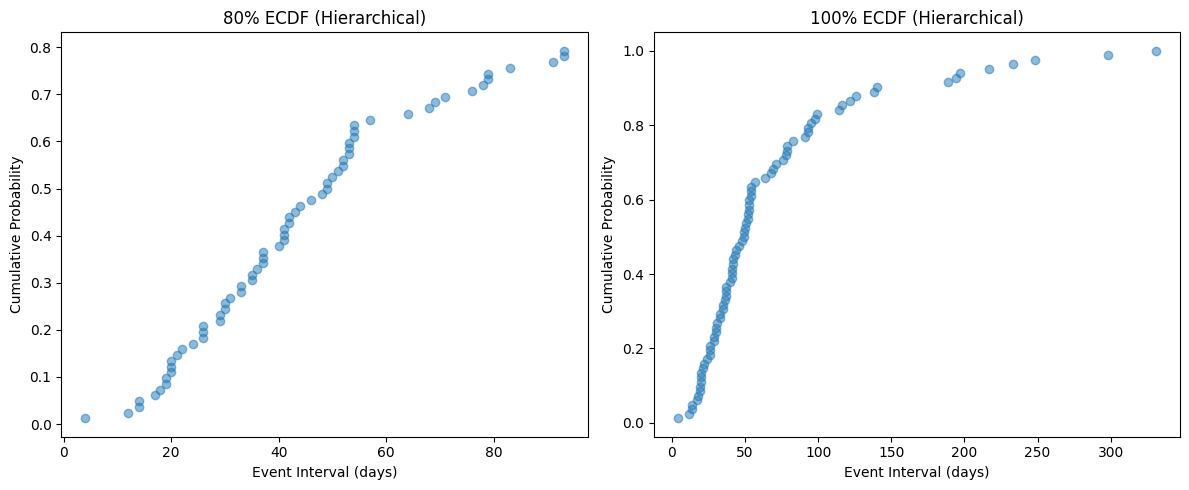

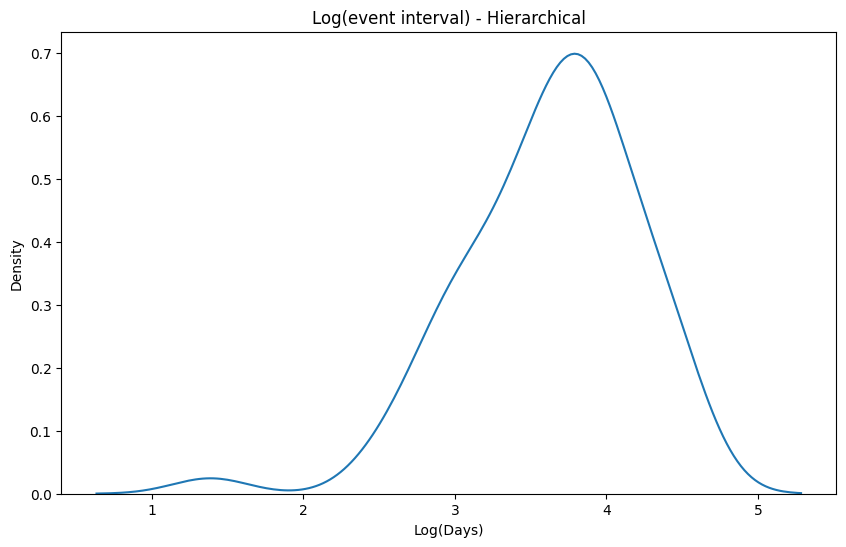

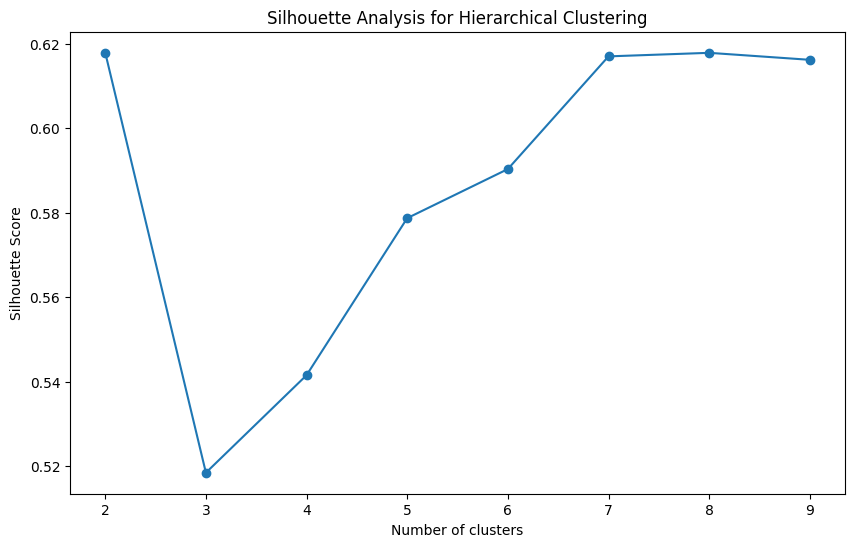

In [67]:
result = sessa_hierarchical(tidy, "medB")
med_b_H = result[0]
med_b_H

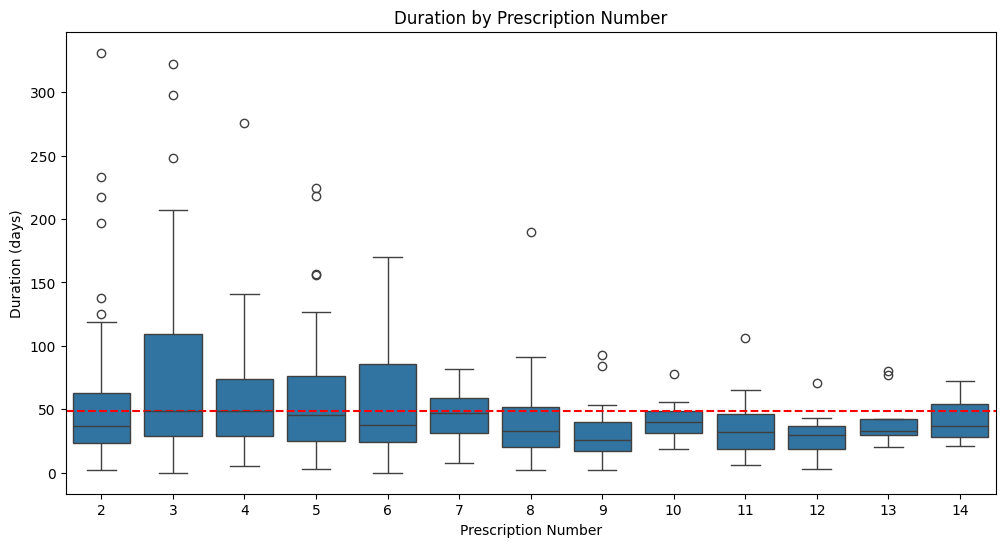

In [68]:
see_assumption(med_b_H)

### **Insights**

Drug: medA
K-means identified 2 clusters with a default median of 41.47 days
Hierarchical clustering identified 3 clusters with a default median of 33.50 days
Absolute difference in median estimation: 7.98 days (19.23%)

Drug: medB
K-means identified 2 clusters with a default median of 32.00 days
Hierarchical clustering identified 2 clusters with a default median of 35.00 days
Absolute difference in median estimation: 3.00 days (9.37%)

#### Overall Comparison:
1. Cluster Structure:
   - K-means tends to create more balanced clusters in terms of size
   - Hierarchical clustering can identify more nuanced patterns but may create less balanced clusters

2. Median Estimation:
   - Average difference between methods: 5.49 days
   - The algorithms showed most agreement for medB (diff: 3.00 days)
   - The algorithms showed least agreement for medA (diff: 7.98 days)

3. Computational Efficiency:
   - K-means is generally faster, especially for larger datasets
   - Hierarchical clustering provides more detailed information about the structure of the data

4. Recommendation:
   - The methods show notable differences, suggesting further investigation is needed
   - Consider domain knowledge and the specific application to choose the most appropriate method

5. Practical Application:
   - For medication adherence analysis, the interval estimates can be used to determine refill patterns
   - Patients with refill intervals significantly longer than the identified median may require intervention
   - The cluster structure can help identify different patient subgroups with distinct behavior patterns